In [1]:
# import library
import pandas as pd
import requests
import tweepy
import os
import numpy as np

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Gather

### (1) Twitter archive

In [2]:
# load CSV
tw_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
tw_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### (2) Image predictions 

In [4]:
# load TSV
if (os.path.exists('image-predictions.tsv') == False):
    url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    response = requests.get(url)
    response

    with open(url.split('/')[-1], mode = 'wb') as outfile:
        outfile.write(response.content)
else:
    print('the file already exists.')
    
img_predictions = pd.read_table('image-predictions.tsv')

the file already exists.


In [5]:
img_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### (3) Twitter additional data

In [6]:
# Gather tweet data
if (os.path.exists('tweet-json.txt') == False):
    # Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
    # These are hidden to comply with Twitter's API terms and conditions
    consumer_key = 'HIDDEN'
    consumer_secret = 'HIDDEN'
    access_token = 'HIDDEN'
    access_secret = 'HIDDEN'

    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    api = tweepy.API(auth, wait_on_rate_limit=True)

    # NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
    # df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
    # change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
    # NOTE TO REVIEWER: this student had mobile verification issues so the following
    # Twitter API code was sent to this student from a Udacity instructor
    # Tweet IDs for which to gather additional data via Twitter's API
    tweet_ids = tw_archive.tweet_id.values
    len(tweet_ids)

    # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
    count = 0
    fails_dict = {}
    start = timer()
    # Save each tweet's returned JSON as a new line in a .txt file
    with open('tweet_json.txt', 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)

else:
    print('the file already exists.')

the file already exists.


In [7]:
# load json type txt.
tw_add = pd.read_table('tweet-json.txt', 
                       header=None,
                       converters={column: json.loads for column in [0]}
                      )

for mykey in tw_add[0][0].keys():
    print(mykey)

created_at
id
id_str
full_text
truncated
display_text_range
entities
extended_entities
source
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
in_reply_to_screen_name
user
geo
coordinates
place
contributors
is_quote_status
retweet_count
favorite_count
favorited
retweeted
possibly_sensitive
possibly_sensitive_appealable
lang


In [8]:
# convert to DataFrame
tweetlist = []
for i in range(len(tw_add)):
    tweetlist.append(tw_add[0][i])
    
tw_add = pd.DataFrame(tweetlist)

In [9]:
tw_add.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,None,...,False,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,None,None,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,None,...,False,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,None,None,Mon Jul 31 00:18:03 +0000 2017,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,None,...,False,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,None,None,Sun Jul 30 15:58:51 +0000 2017,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,None,...,False,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,None,None,Sat Jul 29 16:00:24 +0000 2017,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,None,...,False,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [10]:
# create a list for converting to pd.datafram
tweetlist =[]
with open('tweet-json.txt',encoding = 'utf-8') as file:
    # use for loop to convert txt file line by line to json object
    for line in file.readlines():
        data = json.loads(line)
        tweet_id = data['id_str']
        retweet_count = data['retweet_count']
        favorite_count = data['favorite_count']
        # create dictionary and append it to list
        tweetdic = {'tweet_id': tweet_id,
                    'retweet_count': retweet_count,
                   'favorite_count': favorite_count}
        tweetlist.append(tweetdic)
# convert list to DataFram
json_df = pd.DataFrame(tweetlist)

In [11]:
json_df.head()

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864
3,42908,8964,891689557279858688
4,41048,9774,891327558926688256


# Assess

### (1) Twitter archive

In [12]:
# show info
tw_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
# show statistics
tw_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
# show value counts
tw_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [15]:
# show rows denominator is not 10
tw_archive[tw_archive['rating_denominator']!=10].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,30582082.0,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None


In [16]:
# show doggo counts
tw_archive['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [17]:
# show floofer counts
tw_archive['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [18]:
# show pupper counts
tw_archive['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [19]:
# show puppo counts
tw_archive['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [20]:
# show name counts
tw_archive['name'].value_counts()

None         745
a             55
Charlie       12
Cooper        11
Oliver        11
Lucy          11
Lola          10
Tucker        10
Penny         10
Winston        9
Bo             9
the            8
Sadie          8
an             7
Bailey         7
Buddy          7
Toby           7
Daisy          7
Milo           6
Scout          6
Jax            6
Dave           6
Jack           6
Bella          6
Rusty          6
Leo            6
Oscar          6
Koda           6
Stanley        6
very           5
            ... 
Furzey         1
Dudley         1
Snoop          1
Brandy         1
Kathmandu      1
Florence       1
Boots          1
Josep          1
Tupawc         1
Coopson        1
Alejandro      1
Dwight         1
Ziva           1
Duchess        1
Mary           1
Farfle         1
Carper         1
Edgar          1
Venti          1
Griswold       1
Ebby           1
Anna           1
Gòrdón         1
Maisey         1
Eleanor        1
General        1
Julio          1
Tobi          

In [21]:
# count duplicated tweet id
sum(tw_archive['tweet_id'].duplicated())

0

In [22]:
# count duplicated text
sum(tw_archive['text'].duplicated())

0

In [23]:
# count duplicated URLs
sum(tw_archive['expanded_urls'].duplicated())

137

In [24]:
# count rows reply status is NaN
sum(pd.isnull(tw_archive['in_reply_to_status_id']))

2278

In [25]:
# find rows uses floating rating numerator in text
tw_archive[tw_archive.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,text,rating_numerator
45,This is Bella. She hopes her smile made you sm...,5
340,"RT @dog_rates: This is Logan, the Chow who liv...",75
695,"This is Logan, the Chow who lived. He solemnly...",75
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27
1689,I've been told there's a slight possibility he...,5
1712,Here we have uncovered an entire battalion of ...,26


In [26]:
# multiple dog type
tw_archive.loc[(tw_archive[['doggo', 'floofer', 'pupper', 'puppo']] != 'None').sum(axis=1) > 1]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,None,None,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: Like father (doggo), like son (...",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,https://twitter.com/dog_rates/status/733109485...,12,10,None,doggo,None,pupper,None
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is just downright precious...,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,https://twitter.com/dog_rates/status/741067306...,12,10,just,doggo,None,pupper,None


### (2) Image predictions

In [27]:
# show info 
img_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [28]:
# show statistics
img_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [29]:
# show value counts
img_predictions['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [30]:
# count duplicated tweet id
sum(img_predictions['tweet_id'].duplicated())

0

In [31]:
# count duplicated URLs
sum(img_predictions['jpg_url'].duplicated())

66

### (3)Twitter additional data

In [32]:
# show info
tw_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       2354 non-null object
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null object
id                               2354 non-null int64
id_str                           2354 non-null object
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null object
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null obj

In [33]:
# show statistics
tw_add.describe()

,favorite_count,id,in_reply_to_status_id,in_reply_to_user_id,quoted_status_id,retweet_count
count,2354.000000,2.354000e+03,7.800000e+01,7.800000e+01,2.900000e+01,2354.000000
mean,8080.968564,7.426978e+17,7.455079e+17,2.014171e+16,8.162686e+17,3164.797366
std,11814.771334,6.852812e+16,7.582492e+16,1.252797e+17,6.164161e+16,5284.770364
min,0.000000,6.660209e+17,6.658147e+17,1.185634e+07,6.721083e+17,0.000000
25%,1415.000000,6.783975e+17,6.757419e+17,3.086374e+08,7.888183e+17,624.500000
50%,3603.500000,7.194596e+17,7.038708e+17,4.196984e+09,8.340867e+17,1473.500000
75%,10122.250000,7.993058e+17,8.257804e+17,4.196984e+09,8.664587e+17,3652.000000
max,132810.000000,8.924206e+17,8.862664e+17,8.405479e+17,8.860534e+17,79515.000000


In [34]:
# count duplicated id
sum(tw_add['id'].duplicated())

0

In [35]:
# count rows reply status is NaN
sum(pd.isnull(tw_add['in_reply_to_status_id']))

2276

## Quality

### (1)Twitter archive

・`timestamp` column should be `datetime`.

・`rating_numerator` column should be `float` and also it should be correctly extracted.

・`expanded_urls`　is duplicated.

・`rating_denominator` should be always 10.

・Retweet should not be included.

・Reply should not be included.

・`source` should not include some unnecessary characters as `<a href="http://twitter.com/download/iphone" rel="nofollow">`.

### (2)Image predictions

・`jpg_url` is duplicated. 

・Number of row is not same as `Twitter archive`.

### (3)Twitter additional data

・`timestamp` column should be datetime.

・Number of row is not same as `Twitter archive`.

## Tidiness 

### (1)Twitter archive

・Dog type (doggo, floofer, pupper and puppo) should be in one column.

### (2)Image predictions

・Predicted result should be in one column.

### (3)Twitter additional data

~~・There are unnecessary columns.~~

### (4)All

・　Data should be merged into one DataFrame or file.


# Clean

In [36]:
# copy DataFrams before cleaning
tw_archive_clean = tw_archive.copy()
img_predictions_clean = img_predictions.copy()
tw_add_clean = tw_add.copy()

## Quality

### (1)Twitter archive

### _define_

Convert `timestamp`'s data type to datetime using `pd.to_datetime()`.

### _code_

In [37]:
tw_archive_clean['timestamp'] = pd.to_datetime(tw_archive_clean['timestamp'])

###  _test_

In [38]:
type(tw_archive['timestamp'][0])

str

In [39]:
type(tw_archive_clean['timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

### _define_

Convert `rating_numerator`'s data type to float, extract rows uses float rating and fix itusing regex.

### _code_

In [40]:
tw_archive_clean = tw_archive_clean.astype({'rating_numerator': float})

In [41]:
tw_archive_clean[tw_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,text,rating_numerator
45,This is Bella. She hopes her smile made you sm...,5.0
340,"RT @dog_rates: This is Logan, the Chow who liv...",75.0
695,"This is Logan, the Chow who lived. He solemnly...",75.0
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27.0
1689,I've been told there's a slight possibility he...,5.0
1712,Here we have uncovered an entire battalion of ...,26.0


In [42]:
l = tw_archive_clean[tw_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']].index
for i in range(len(l.values)):
    clm = l.values[i]
    s = tw_archive_clean.loc[clm, "text"]
    extrct_str = re.search(r'(\d+\.\d+)', s).group()
    print(extrct_str)
    tw_archive_clean.loc[clm, "rating_numerator"] = float(extrct_str)

13.5
9.75
9.75
11.27
9.5
11.26


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


### _test_

In [43]:
tw_archive_clean[tw_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,text,rating_numerator
45,This is Bella. She hopes her smile made you sm...,13.50
340,"RT @dog_rates: This is Logan, the Chow who liv...",9.75
695,"This is Logan, the Chow who lived. He solemnly...",9.75
763,This is Sophie. She's a Jubilant Bush Pupper. ...,11.27
1689,I've been told there's a slight possibility he...,9.50
1712,Here we have uncovered an entire battalion of ...,11.26


In [44]:
tw_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null float64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns]

### _define_

Remove duplication of `expanded_urls`　using `duplicated()`.

### _code_

In [45]:
tw_archive_clean = tw_archive_clean[~tw_archive_clean['expanded_urls'].duplicated()]

###  _test_

In [46]:
sum(tw_archive['expanded_urls'].duplicated())

137

In [47]:
sum(tw_archive_clean['expanded_urls'].duplicated())

0

### _define_

Drop rows that `rating_denominator` is not 10.

### _code_

In [48]:
tw_archive_clean = tw_archive_clean[tw_archive_clean['rating_denominator'] == 10]

###  _test_

In [49]:
tw_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [50]:
tw_archive_clean['rating_denominator'].value_counts()

10    2201
Name: rating_denominator, dtype: int64

### _define_

Remove Retweet. 

### _code_

In [51]:
tw_archive_clean = tw_archive_clean[pd.isnull(tw_archive_clean['retweeted_status_user_id'])]

###  _test_

In [52]:
tw_archive['retweeted_status_user_id'].value_counts()

4.196984e+09    156
4.296832e+09      2
5.870972e+07      1
6.669901e+07      1
4.119842e+07      1
7.475543e+17      1
7.832140e+05      1
7.266347e+08      1
4.871977e+08      1
5.970642e+08      1
4.466750e+07      1
1.228326e+09      1
7.992370e+07      1
2.488557e+07      1
7.874618e+17      1
3.638908e+08      1
5.128045e+08      1
8.117408e+08      1
1.732729e+09      1
1.960740e+07      1
1.547674e+08      1
3.410211e+08      1
7.124572e+17      1
2.804798e+08      1
1.950368e+08      1
Name: retweeted_status_user_id, dtype: int64

In [53]:
tw_archive_clean['retweeted_status_user_id'].value_counts()

Series([], Name: retweeted_status_user_id, dtype: int64)

### _define_

Remove Reply.

### _code_

In [54]:
tw_archive_clean = tw_archive_clean[pd.isnull(tw_archive_clean['in_reply_to_user_id'])]

###  _test_

In [55]:
tw_archive['in_reply_to_user_id'].value_counts()

4.196984e+09    47
2.195506e+07     2
7.305050e+17     1
2.916630e+07     1
3.105441e+09     1
2.918590e+08     1
2.792810e+08     1
2.319108e+09     1
1.806710e+08     1
3.058208e+07     1
2.625958e+07     1
1.943518e+08     1
3.589728e+08     1
8.405479e+17     1
2.894131e+09     1
2.143566e+07     1
2.281182e+09     1
1.648776e+07     1
4.717297e+09     1
2.878549e+07     1
1.582854e+09     1
4.670367e+08     1
4.738443e+07     1
1.361572e+07     1
1.584641e+07     1
2.068372e+07     1
1.637468e+07     1
1.185634e+07     1
1.198989e+09     1
1.132119e+08     1
7.759620e+07     1
Name: in_reply_to_user_id, dtype: int64

In [56]:
tw_archive_clean['in_reply_to_user_id'].value_counts()

Series([], Name: in_reply_to_user_id, dtype: int64)

In [57]:
tw_archive_clean.reset_index(drop=True, inplace=True)

In [58]:
tw_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 17 columns):
tweet_id                      1999 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1999 non-null datetime64[ns]
source                        1999 non-null object
text                          1999 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1999 non-null object
rating_numerator              1999 non-null float64
rating_denominator            1999 non-null int64
name                          1999 non-null object
doggo                         1999 non-null object
floofer                       1999 non-null object
pupper                        1999 non-null object
puppo                         1999 non-null object
dtypes: datetime64[ns](1), flo

### _define_

Remove some unnecessary characters as `<a href="http://twitter.com/download/iphone" rel="nofollow">` in `source`.

### _code_

In [59]:
tw_archive_clean['source'] = tw_archive_clean['source'].str.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'Twitter for iPhone')
tw_archive_clean['source'] = tw_archive_clean['source'].str.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>','Vine - Make a Scene')
tw_archive_clean['source'] = tw_archive_clean['source'].str.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>','Twitter Web Client')
tw_archive_clean['source'] = tw_archive_clean['source'].str.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>','TweetDeck')

###  _test_

In [60]:
tw_archive['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [61]:
tw_archive_clean['source'].value_counts()

Twitter for iPhone     1869
Vine - Make a Scene      90
Twitter Web Client       30
TweetDeck                10
Name: source, dtype: int64

### (2)Image predictions

### _define_

Remove duplication of `jpg_url` using `duplicatee()`.

### _code_

In [62]:
img_predictions_clean = img_predictions_clean[~img_predictions_clean['jpg_url'].duplicated()]

###  _test_

In [63]:
sum(img_predictions['jpg_url'].duplicated())

66

In [64]:
sum(img_predictions_clean['jpg_url'].duplicated())

0

In [65]:
img_predictions_clean.reset_index(drop=True, inplace=True)

In [66]:
img_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2009 entries, 0 to 2008
Data columns (total 12 columns):
tweet_id    2009 non-null int64
jpg_url     2009 non-null object
img_num     2009 non-null int64
p1          2009 non-null object
p1_conf     2009 non-null float64
p1_dog      2009 non-null bool
p2          2009 non-null object
p2_conf     2009 non-null float64
p2_dog      2009 non-null bool
p3          2009 non-null object
p3_conf     2009 non-null float64
p3_dog      2009 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 147.2+ KB


### _define_

Number of row is not same as `Twitter archive`.

### _code_

In [67]:
tw_archive_clean.shape, img_predictions_clean.shape

((1999, 17), (2009, 12))

In [68]:
index_of_no_img_prediction = []

for i in range(len(tw_archive_clean)):
    if(sum(img_predictions_clean['tweet_id'] == tw_archive_clean.loc[i, 'tweet_id']) != 1):
        index_of_no_img_prediction.append(i)
        
len(index_of_no_img_prediction)

122

In [69]:
tw_archive_clean.drop(index=index_of_no_img_prediction, inplace=True)
tw_archive_clean.reset_index(drop=True, inplace=True)

In [70]:
index_of_no_img_prediction = []

for i in range(len(tw_archive_clean)):
    if(sum(img_predictions_clean['tweet_id'] == tw_archive_clean.loc[i, 'tweet_id']) != 1):
        index_of_no_img_prediction.append(i)
        
len(index_of_no_img_prediction)

0

In [71]:
index_of_no_tw = []

for i in range(len(img_predictions_clean)):
    if(sum(tw_archive_clean['tweet_id'] == img_predictions_clean.loc[i, 'tweet_id']) != 1):
        index_of_no_tw.append(i)

len(index_of_no_tw)

132

In [72]:
img_predictions_clean.drop(index=index_of_no_tw, inplace=True)
img_predictions_clean.reset_index(drop=True, inplace=True)

In [73]:
index_of_no_tw = []

for i in range(len(img_predictions_clean)):
    if(sum(tw_archive_clean['tweet_id'] == img_predictions_clean.loc[i, 'tweet_id']) != 1):
        index_of_no_tw.append(i)

len(index_of_no_tw)

0

###  _test_

In [74]:
tw_archive_clean.shape, img_predictions_clean.shape

((1877, 17), (1877, 12))

### (3)Twitter additional data

### _define_

Convert `timestamp`'s data type to datetime using `pd.to_datetime()`.

### _code_

In [75]:
tw_add_clean['created_at'] = pd.to_datetime(tw_add_clean['created_at'])

### _test_

In [76]:
type(tw_add['created_at'][0])

str

In [77]:
type(tw_add_clean['created_at'][0])

pandas._libs.tslibs.timestamps.Timestamp

### _define_

Number of row is not same as `Twitter archive`.

### _code_

In [78]:
tw_archive_clean.shape, tw_add_clean.shape

((1877, 17), (2354, 31))

In [79]:
index_list = []

for i in range(len(tw_archive_clean)):
    if(sum(tw_add_clean['id'] == tw_archive_clean.loc[i, 'tweet_id']) != 1):
        index_list.append(i)

len(index_list)

0

In [80]:
index_list = []

for i in range(len(tw_add_clean)):
    if(sum(tw_archive_clean['tweet_id'] == tw_add_clean.loc[i, 'id']) != 1):
        index_list.append(i)

len(index_list)

477

In [81]:
tw_add_clean.drop(index=index_list, inplace=True)
tw_add_clean.reset_index(drop=True, inplace=True)

###  _test_

In [82]:
tw_archive_clean.shape, tw_add_clean.shape

((1877, 17), (1877, 31))

## Tidiness

### (1)Twitter archive

### _define_

Dog type (doggo, floofer, pupper and puppo) should be in one column using `melt`. (Pay attention. There are rows have multiple dog types.)

### _code_

In [83]:
df_melt = pd.melt(tw_archive_clean,
                                    id_vars = 'tweet_id',
                                    value_name='dog_type',
                                    value_vars = ['doggo', 'floofer', 'pupper', 'puppo'])

In [84]:
df_melt.head()

,tweet_id,variable,dog_type
0,892420643555336193,doggo,None
1,892177421306343426,doggo,None
2,891815181378084864,doggo,None
3,891689557279858688,doggo,None
4,891327558926688256,doggo,None


In [85]:
tw_archive_clean[tw_archive_clean['doggo'] == 'doggo'].head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14.0,10,Cassie,doggo,None,None,None
37,884162670584377345,NaN,NaN,2017-07-09 21:29:42,Twitter for iPhone,Meet Yogi. He doesn't have any important dog m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670...,12.0,10,Yogi,doggo,None,None,None
78,872967104147763200,NaN,NaN,2017-06-09 00:02:31,Twitter for iPhone,Here's a very large dog. He has a date later. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872967104...,12.0,10,None,doggo,None,None,None


In [86]:
df_melt[df_melt['dog_type'] == 'doggo'].head(3)

,tweet_id,variable,dog_type
9,890240255349198849,doggo,doggo
37,884162670584377345,doggo,doggo
78,872967104147763200,doggo,doggo


In [87]:
df_melt.shape

(7508, 3)

In [88]:
df_melt['dog_type'] = df_melt['dog_type'].str.title()

In [89]:
df_melt = df_melt[df_melt['dog_type']!='None']

In [90]:
df_melt.drop_duplicates(inplace = True)

In [91]:
df_melt[df_melt['tweet_id'].duplicated()]

,tweet_id,variable,dog_type
2020,854010172552949760,floofer,Floofer
4064,817777686764523521,pupper,Pupper
4115,808106460588765185,pupper,Pupper
4142,801115127852503040,pupper,Pupper
4223,785639753186217984,pupper,Pupper
4351,759793422261743616,pupper,Pupper
4399,751583847268179968,pupper,Pupper
4487,741067306818797568,pupper,Pupper
4529,733109485275860992,pupper,Pupper
5768,855851453814013952,puppo,Puppo


In [92]:
df_melt.loc[df_melt['tweet_id'].duplicated(), "dog_type"] = "multiple"

In [93]:
df_melt = df_melt.groupby('tweet_id').max().reset_index()

In [94]:
df_melt[df_melt['tweet_id'].duplicated()]

,tweet_id,variable,dog_type


In [95]:
df_melt

,tweet_id,variable,dog_type
0,672160042234327040,pupper,Pupper
1,672205392827572224,pupper,Pupper
2,672254177670729728,pupper,Pupper
3,672481316919734272,pupper,Pupper
4,672594978741354496,pupper,Pupper
5,672614745925664768,pupper,Pupper
6,672622327801233409,pupper,Pupper
7,672898206762672129,pupper,Pupper
8,672970152493887488,pupper,Pupper
9,672975131468300288,pupper,Pupper


In [96]:
df_melt.shape

(285, 3)

In [97]:
df_melt = df_melt.reset_index(drop=True)

In [98]:
tw_archive_clean = tw_archive_clean.merge(df_melt, how = 'left')

In [99]:
columns = ['variable', 'doggo', 'floofer', 'pupper', 'puppo']
tw_archive_clean = tw_archive_clean.drop(columns, axis = 1)

###  _test_

In [100]:
tw_archive_clean[~tw_archive_clean['dog_type'].isnull()][['tweet_id','dog_type']].head(10)

,tweet_id,dog_type
9,890240255349198849,Doggo
12,889665388333682689,Puppo
14,889531135344209921,Puppo
28,886366144734445568,Pupper
37,884162670584377345,Doggo
40,883360690899218434,Floofer
43,882762694511734784,Pupper
49,881536004380872706,Pupper
62,878776093423087618,Puppo
67,876838120628539392,Pupper


In [101]:
tw_archive[tw_archive['doggo']!='None'][['tweet_id', 'doggo', 'floofer', 'pupper', 'puppo']].head(2)

,tweet_id,doggo,floofer,pupper,puppo
9,890240255349198849,doggo,None,None,None
43,884162670584377345,doggo,None,None,None


In [102]:
tw_archive[tw_archive['floofer']!='None'][['tweet_id', 'doggo', 'floofer', 'pupper', 'puppo']].head(1)

,tweet_id,doggo,floofer,pupper,puppo
46,883360690899218434,None,floofer,None,None


In [103]:
tw_archive[tw_archive['pupper']!='None'][['tweet_id', 'doggo', 'floofer', 'pupper', 'puppo']].head(5)

,tweet_id,doggo,floofer,pupper,puppo
29,886366144734445568,None,None,pupper,None
49,882762694511734784,None,None,pupper,None
56,881536004380872706,None,None,pupper,None
78,877611172832227328,None,None,pupper,None
82,876838120628539392,None,None,pupper,None


In [104]:
tw_archive[tw_archive['puppo']!='None'][['tweet_id', 'doggo', 'floofer', 'pupper', 'puppo']].head(3)

,tweet_id,doggo,floofer,pupper,puppo
12,889665388333682689,None,None,None,puppo
14,889531135344209921,None,None,None,puppo
71,878776093423087618,None,None,None,puppo


### (2)Image predictions

### _define_

Prediction result in one column.

### _code_

In [105]:
for i in range(len(img_predictions_clean)):
    if(img_predictions_clean.loc[i, 'p1_dog'] == False):
        if(img_predictions_clean.loc[i, 'p2_dog'] == True):
            img_predictions_clean.loc[i, 'p1'] = img_predictions_clean.loc[i, 'p2']
            img_predictions_clean.loc[i, 'p1_conf'] = img_predictions_clean.loc[i, 'p2_conf']
            img_predictions_clean.loc[i, 'p1_dog'] = img_predictions_clean.loc[i, 'p2_dog']
            
        elif(img_predictions_clean.loc[i, 'p3_dog'] == True):
            img_predictions_clean.loc[i, 'p1'] = img_predictions_clean.loc[i, 'p3']
            img_predictions_clean.loc[i, 'p1_conf'] = img_predictions_clean.loc[i, 'p3_conf']
            img_predictions_clean.loc[i, 'p1_dog'] = img_predictions_clean.loc[i, 'p3_dog']

In [106]:
img_predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [107]:
img_predictions_clean[img_predictions_clean['p1'] == img_predictions_clean['p2']].head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
20,666337882303524864,https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg,1,Newfoundland,0.278407,True,Newfoundland,0.278407,True,groenendael,0.102643,True
31,666430724426358785,https://pbs.twimg.com/media/CT-jNYqW4AAPi2M.jpg,1,Irish_terrier,0.104109,True,Irish_terrier,0.104109,True,dingo,0.062071,False
41,666776908487630848,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,1,miniature_pinscher,0.167175,True,miniature_pinscher,0.167175,True,Chihuahua,0.086951,True
50,666996132027977728,https://pbs.twimg.com/media/CUGlb6iUwAITEbW.jpg,1,Rottweiler,0.062490,True,Rottweiler,0.062490,True,water_buffalo,0.048425,False
96,667806454573760512,https://pbs.twimg.com/media/CUSGbXeVAAAgztZ.jpg,1,Chihuahua,0.187155,True,Chihuahua,0.187155,True,Brabancon_griffon,0.112799,True


In [108]:
img_predictions.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


###  _test_

In [109]:
sum((img_predictions['p1_dog'] == False) & (img_predictions['p2_dog'] == True))

155

In [110]:
sum((img_predictions['p1_dog'] == False) & (img_predictions['p2_dog'] == False) & (img_predictions['p3_dog'] == True))

64

In [111]:
sum((img_predictions_clean['p1_dog'] == False) & (img_predictions_clean['p2_dog'] == True))

0

In [112]:
sum((img_predictions_clean['p1_dog'] == False) & (img_predictions_clean['p2_dog'] == False) & (img_predictions_clean['p3_dog'] == True))

0

In [113]:
columns = ['p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']
img_predictions_clean = img_predictions_clean.drop(columns, axis = 1)

In [114]:
img_predictions_clean.rename(columns={'p1': 'Prediction', 'p1_conf': 'Confidence', 'p1_dog' : 'Dog_or_not'}, inplace=True)

In [115]:
img_predictions_clean.head()

,tweet_id,jpg_url,img_num,Prediction,Confidence,Dog_or_not
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True


### (3)Twitter additional data

### _define_

~~There are unneccesary columns.~~

### _code_

In [116]:
# tw_add_clean.columns

In [117]:
# tw_add_clean[~pd.isnull(tw_add_clean['contributors'])]

In [118]:
# tw_add_clean[~pd.isnull(tw_add_clean['coordinates'])]

In [119]:
# sum(tw_add_clean['favorited'] != False)

In [120]:
# tw_add_clean[tw_add_clean['favorited'] != False]

In [121]:
# sum(tw_add_clean['retweeted'] != False)

In [122]:
# tw_add_clean[~pd.isnull(tw_add_clean['retweeted_status'])]

In [123]:
# sum(tw_add_clean['truncated'] != False)

In [124]:
# tw_add_clean[~pd.isnull(tw_add_clean['geo'])]

In [125]:
# tw_add_clean['lang'].value_counts()

In [126]:
# sum(tw_add_clean['possibly_sensitive'] != False)

In [127]:
# sum(tw_add_clean['possibly_sensitive_appealable'] != False)

In [128]:
# tw_add_clean[~pd.isnull(tw_add_clean['place'])]

In [129]:
#columns = ['contributors', 'coordinates', 'entities', 'extended_entities', 'geo', 'lang', 'possibly_sensitive', 'possibly_sensitive_appealable', 
#           'favorited', 'retweeted', 'retweeted_status', 'in_reply_to_screen_name', 'in_reply_to_status_id', 
#           'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'place',
#           'is_quote_status', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'truncated', 'user']
#tw_add_clean = tw_add_clean.drop(columns, axis = 1)

In [130]:
#tw_add_clean['source'] = tw_add_clean['source'].str.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'Twitter for iPhone')
#tw_add_clean['source'] = tw_add_clean['source'].str.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>','Vine - Make a Scene')
#tw_add_clean['source'] = tw_add_clean['source'].str.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>','Twitter Web Client')
#tw_add_clean['source'] = tw_add_clean['source'].str.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>','TweetDeck')

###  _test_

In [131]:
#tw_add_clean.head()

## Merge & Save

In [132]:
tw_clean = pd.merge(tw_add_clean, tw_archive_clean, left_on='id', right_on='tweet_id')

In [133]:
tw_archive_master = pd.merge(tw_clean, img_predictions_clean, on='tweet_id')

In [134]:
tw_archive_master

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,expanded_urls,rating_numerator,rating_denominator,name,dog_type,jpg_url,img_num,Prediction,Confidence,Dog_or_not
0,None,None,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,None,...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False
1,None,None,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,None,...,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True
2,None,None,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,None,...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True
3,None,None,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,None,...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_retriever,0.168086,True
4,None,None,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,None,...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True
5,None,None,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,None,...,https://twitter.com/dog_rates/status/891087950...,13.0,10,None,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True
6,None,None,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,None,...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,10,Jax,NaN,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,True
7,None,None,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,None,...,https://twitter.com/dog_rates/status/890729181...,13.0,10,None,NaN,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True
8,None,None,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,None,...,https://twitter.com/dog_rates/status/890609185...,13.0,10,Zoey,NaN,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,0.487574,True
9,None,None,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,None,...,https://twitter.com/dog_rates/status/890240255...,14.0,10,Cassie,Doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,Pembroke,0.511319,True


In [135]:
#extract only rows predicted as dog over 30% confidence
tw_archive_master = tw_archive_master[tw_archive_master['Dog_or_not'] == True]
tw_archive_master = tw_archive_master[tw_archive_master['Confidence'] > 0.3]

In [136]:
tw_archive_master.to_csv('twitter_archive_master.csv', index=False, encoding = 'utf-8')

In [137]:
df = pd.read_csv('twitter_archive_master.csv')

In [138]:
df

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,expanded_urls,rating_numerator,rating_denominator,name,dog_type,jpg_url,img_num,Prediction,Confidence,Dog_or_not
0,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True
1,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True
2,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True
3,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,NaN,...,https://twitter.com/dog_rates/status/891087950...,13.0,10,None,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True
4,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,10,Jax,NaN,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,True
5,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,NaN,...,https://twitter.com/dog_rates/status/890729181...,13.0,10,None,NaN,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True
6,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,NaN,...,https://twitter.com/dog_rates/status/890609185...,13.0,10,Zoey,NaN,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,0.487574,True
7,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,NaN,...,https://twitter.com/dog_rates/status/890240255...,14.0,10,Cassie,Doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,Pembroke,0.511319,True
8,NaN,NaN,2017-07-26 00:31:25,"[0, 130]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890006600089468928, 'id_str'...",31166,False,This is Koda. He is a South Australian decksha...,NaN,...,https://twitter.com/dog_rates/status/890006608...,13.0,10,Koda,NaN,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,1,Samoyed,0.957979,True
9,NaN,NaN,2017-07-25 16:11:53,"[0, 107]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 889880888800096258, 'id_str'...",28268,False,This is Bruno. He is a service shark. Only get...,NaN,...,https://twitter.com/dog_rates/status/889880896...,13.0,10,Bruno,NaN,https://pbs.twimg.com/media/DFl99B1WsAITKsg.jpg,1,French_bulldog,0.377417,True


In [139]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189 entries, 0 to 1188
Data columns (total 50 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       1189 non-null object
display_text_range               1189 non-null object
entities                         1189 non-null object
extended_entities                1189 non-null object
favorite_count                   1189 non-null int64
favorited                        1189 non-null bool
full_text                        1189 non-null object
geo                              0 non-null float64
id                               1189 non-null int64
id_str                           1189 non-null int64
in_reply_to_screen_name          0 non-null float64
in_reply_to_status_id_x          0 non-null float64
in_reply_to_status_id_str        0 non-null float64
in_reply_to_user_id_x            0 non-null float64
in_reply_to_user_id_str          0 non-null floa

# Analyze

#### (1)Is there relationship between rate and fav, rtwt?

(0, 20)

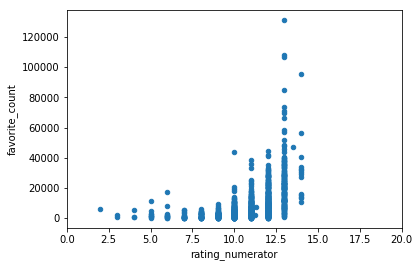

In [141]:
df.plot.scatter(x='rating_numerator', y='favorite_count')
plt.xlim([0,20])

(0, 20)

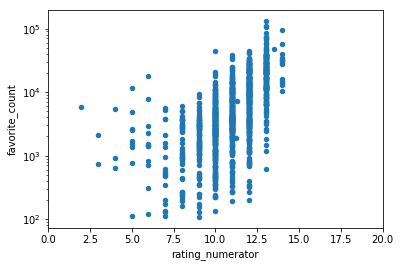

In [142]:
df.plot.scatter(x='rating_numerator', y='favorite_count',logy=True)
plt.xlim([0,20])

(0, 20)

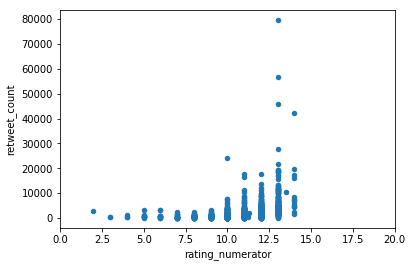

In [143]:
df.plot.scatter(x='rating_numerator', y='retweet_count')
plt.xlim([0,20])

(0, 20)

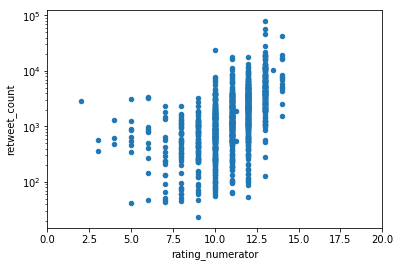

In [144]:
df.plot.scatter(x='rating_numerator', y='retweet_count', logy=True)
plt.xlim([0,20])

#### (2)What type of dog is most favorited and retweeted?

In [145]:
top20 = df.sort_values('retweet_count', ascending=False)[0:20]['id'].values
for i in range(len(top20)):
    print(i)
    print(df[df['id'] == top20[i]]['retweet_count'].values[0])
    print(df[df['id'] == top20[i]]['dog_type'].values[0])
    print(df[df['id'] == top20[i]]['Prediction'].values[0])

0
79515
Doggo
Labrador_retriever
1
56625
nan
Chihuahua
2
45849
nan
English_springer
3
42228
Doggo
standard_poodle
4
27680
nan
golden_retriever
5
24319
nan
Labrador_retriever
6
21840
nan
chow
7
19669
Puppo
Rottweiler
8
19297
nan
Labrador_retriever
9
19196
multiple
flat-coated_retriever
10
18781
nan
Pembroke
11
18627
nan
boxer
12
18497
Floofer
Samoyed
13
17621
multiple
golden_retriever
14
17605
nan
Great_Pyrenees
15
17300
nan
Chesapeake_Bay_retriever
16
17209
Pupper
Pomeranian
17
16716
nan
Pomeranian
18
16628
nan
golden_retriever
19
16267
nan
French_bulldog


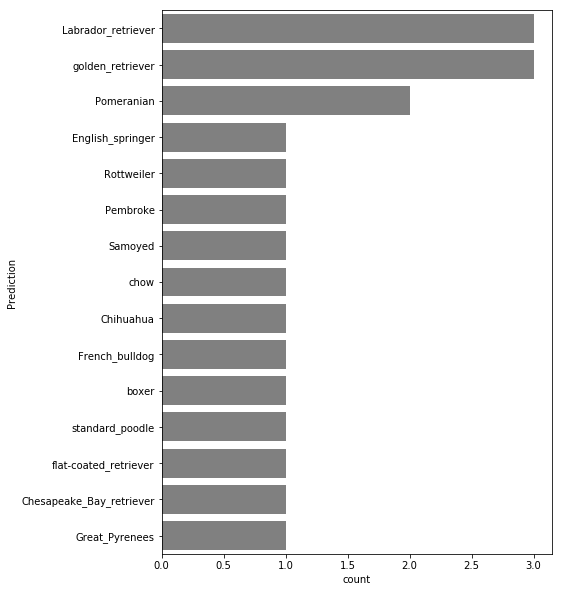

In [146]:
top20 = df.sort_values('retweet_count', ascending=False)[0:20]
plt.figure(figsize=(7, 10))
ax = sns.countplot(y="Prediction", data=top20, color="gray", order = top20['Prediction'].value_counts().index)

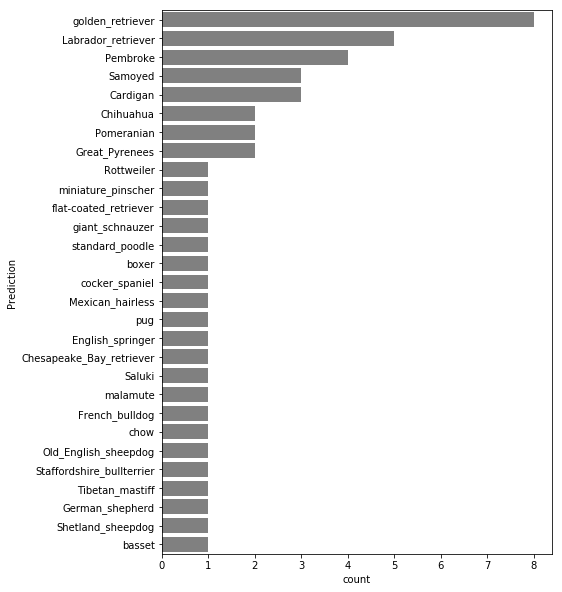

In [147]:
top50 = df.sort_values('retweet_count', ascending=False)[0:50]
plt.figure(figsize=(7, 10))
ax = sns.countplot(y="Prediction", data=top50, color="gray", order = top50['Prediction'].value_counts().index)

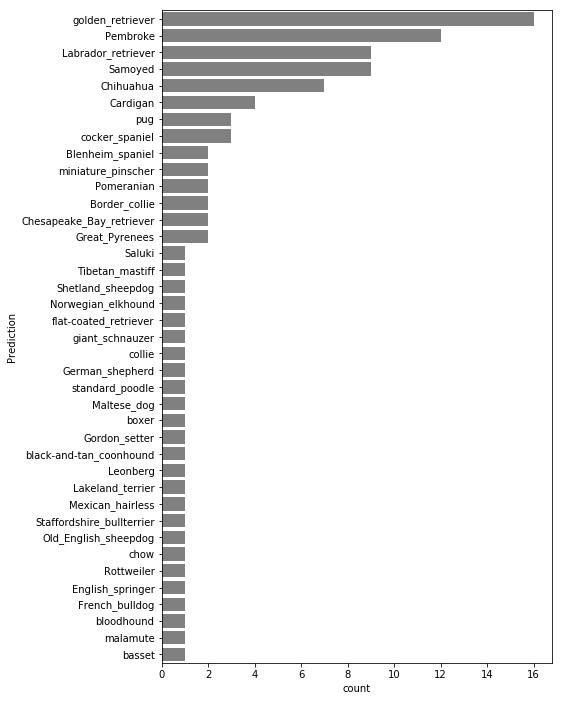

In [148]:
top100 = df.sort_values('retweet_count', ascending=False)[0:100]
plt.figure(figsize=(7, 12))
ax = sns.countplot(y="Prediction", data=top100, color="gray", order = top100['Prediction'].value_counts().index)

In [149]:
top20 = df.sort_values('favorite_count', ascending=False)[0:20]['id'].values
for i in range(len(top20)):
    print(i)
    print(df[df['id'] == top20[i]]['favorite_count'].values[0])
    print(df[df['id'] == top20[i]]['dog_type'].values[0])
    print(df[df['id'] == top20[i]]['Prediction'].values[0])

0
131075
Doggo
Labrador_retriever
1
107956
nan
English_springer
2
107015
nan
Chihuahua
3
95450
Doggo
standard_poodle
4
85011
nan
golden_retriever
5
73397
nan
Labrador_retriever
6
71144
nan
Chesapeake_Bay_retriever
7
69871
nan
Pembroke
8
66437
nan
chow
9
58302
nan
boxer
10
56848
nan
Pomeranian
11
56413
Puppo
Rottweiler
12
51522
nan
Saluki
13
48410
Doggo
golden_retriever
14
47844
multiple
flat-coated_retriever
15
46860
nan
golden_retriever
16
45880
nan
golden_retriever
17
44619
multiple
golden_retriever
18
43710
nan
Pembroke
19
43694
nan
Labrador_retriever


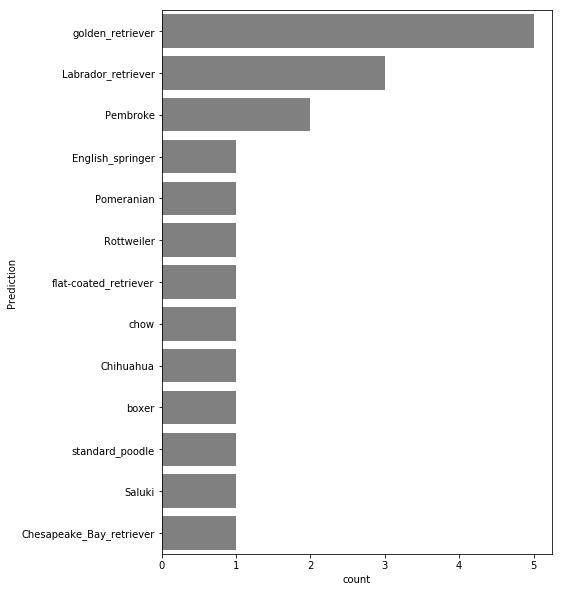

In [150]:
top20 = df.sort_values('favorite_count', ascending=False)[0:20]
plt.figure(figsize=(7, 10))
ax = sns.countplot(y="Prediction", data=top20, color="gray", order = top20['Prediction'].value_counts().index)

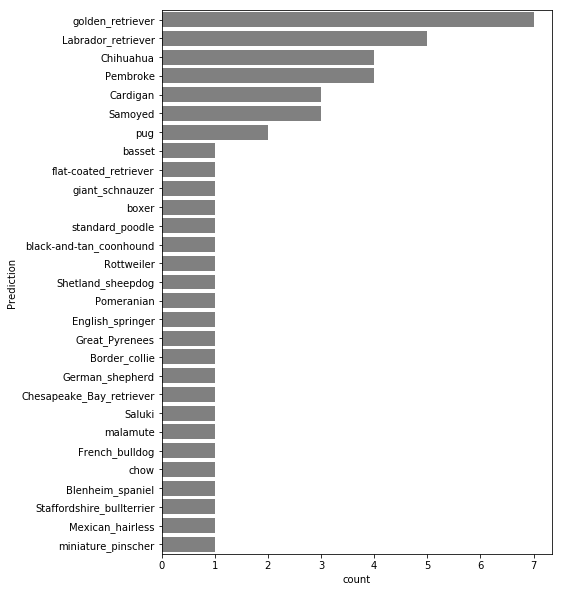

In [151]:
top50 = df.sort_values('favorite_count', ascending=False)[0:50]
plt.figure(figsize=(7, 10))
ax = sns.countplot(y="Prediction", data=top50, color="gray", order = top50['Prediction'].value_counts().index)

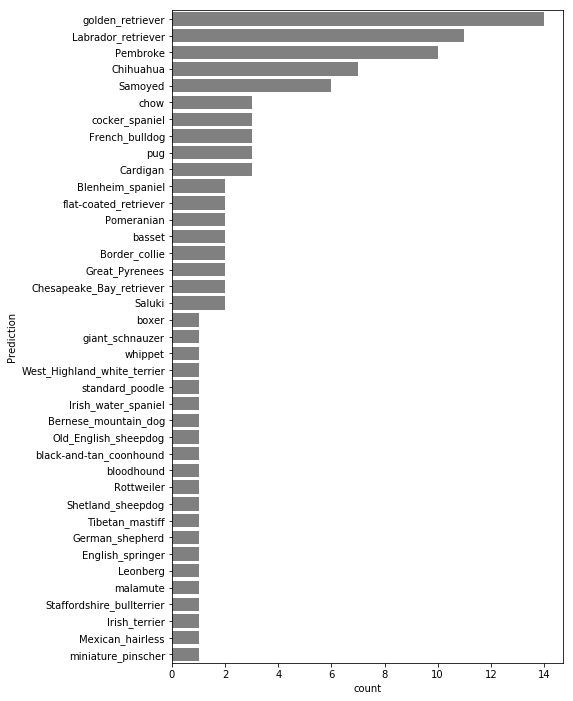

In [152]:
top100 = df.sort_values('favorite_count', ascending=False)[0:100]
plt.figure(figsize=(7, 12))
ax = sns.countplot(y="Prediction", data=top100, color="gray", order = top100['Prediction'].value_counts().index)

#### (3)When we tweet if want to get more fav and retwt?

In [153]:
df['hour'] = 0
for i in range(len(df)):
    df.loc[i,'hour'] = df.loc[i, 'timestamp'].hour

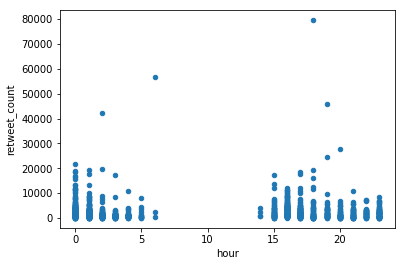

In [154]:
df.plot.scatter(x='hour', y='retweet_count')

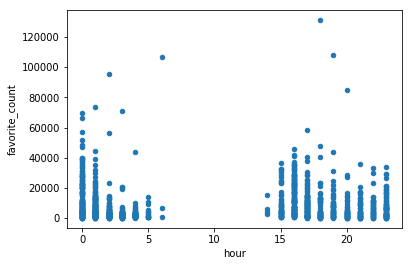

In [155]:
df.plot.scatter(x='hour', y='favorite_count')